In [15]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Define the path to the 'rating' subfolder
rating_folder_path = "../results/rating"

# Recursively list all csv files in the 'free' folder
csv_files = []
for root, dirs, files in os.walk(rating_folder_path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

# Read and concatenate all CSV files
dfs = [pd.read_csv(csv_file) for csv_file in csv_files]
concatenated_df = pd.concat(dfs, ignore_index=True)

# Display the shape and a sample of the concatenated DataFrame
shape = concatenated_df.shape
sample_data = concatenated_df.head()

shape, sample_data

((7692, 17),
                  model_name  temperature  seed  item_id       phenomenon  \
 0  meta-llama/Llama-2-7b-hf          0.1     0        1  indirect_speech   
 1  meta-llama/Llama-2-7b-hf          0.1     0        1  indirect_speech   
 2  meta-llama/Llama-2-7b-hf          0.1     0        1  indirect_speech   
 3  meta-llama/Llama-2-7b-hf          0.1     0        1  indirect_speech   
 4  meta-llama/Llama-2-7b-hf          0.1     0        2  indirect_speech   
 
                                               prompt  \
 0  You will read a short story that describes an ...   
 1  You will read a short story that describes an ...   
 2  You will read a short story that describes an ...   
 3  You will read a short story that describes an ...   
 4  You will read a short story that describes an ...   
 
                                         prior_prompt question  \
 0  You will read a short story that describes an ...      NaN   
 1  You will read a short story that describes 

In [3]:
# Checking for NA values in the concatenated DataFrame
na_values = concatenated_df.isnull().sum()

na_values


model_name                       0
temperature                      0
seed                             0
item_id                          0
phenomenon                       0
prompt                           0
prior_prompt                     0
question                      5820
options                          0
option_names                     0
scale                            0
rating_options                   0
weighted_options                 0
chosen_option                    0
token_cond_log_probs             0
prior_token_log_probs            0
null_prior_token_log_probs       0
dtype: int64

In [13]:
# Grouping by the specified columns and calculating mean and standard deviation for 'weighted_options'
grouped_df = concatenated_df.groupby(['phenomenon', 'option_names', 'item_id', 'model_name', 'scale'])['weighted_options'].agg(['mean'])

grouped_df.reset_index(inplace=True)
grouped_df.head()


print(grouped_df.shape)
print(grouped_df.isnull().sum())
print(grouped_df.head())

(7692, 6)
phenomenon      0
option_names    0
item_id         0
model_name      0
scale           0
mean            0
dtype: int64
  phenomenon option_names  item_id              model_name        scale  \
0  coherence   competitor        1       google/flan-t5-xl  appropriate   
1  coherence   competitor        1       google/flan-t5-xl       likely   
2  coherence   competitor        1       google/flan-t5-xl    plausible   
3  coherence   competitor        1       google/flan-t5-xl     possible   
4  coherence   competitor        1  gpt-3.5-turbo-instruct  appropriate   

      mean  
0  3.00000  
1  3.00000  
2  3.00000  
3  3.00000  
4  2.76909  


/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_31202/1817398596.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_31202/1817398596.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_31202/1817398596.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_31202/1817398596.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

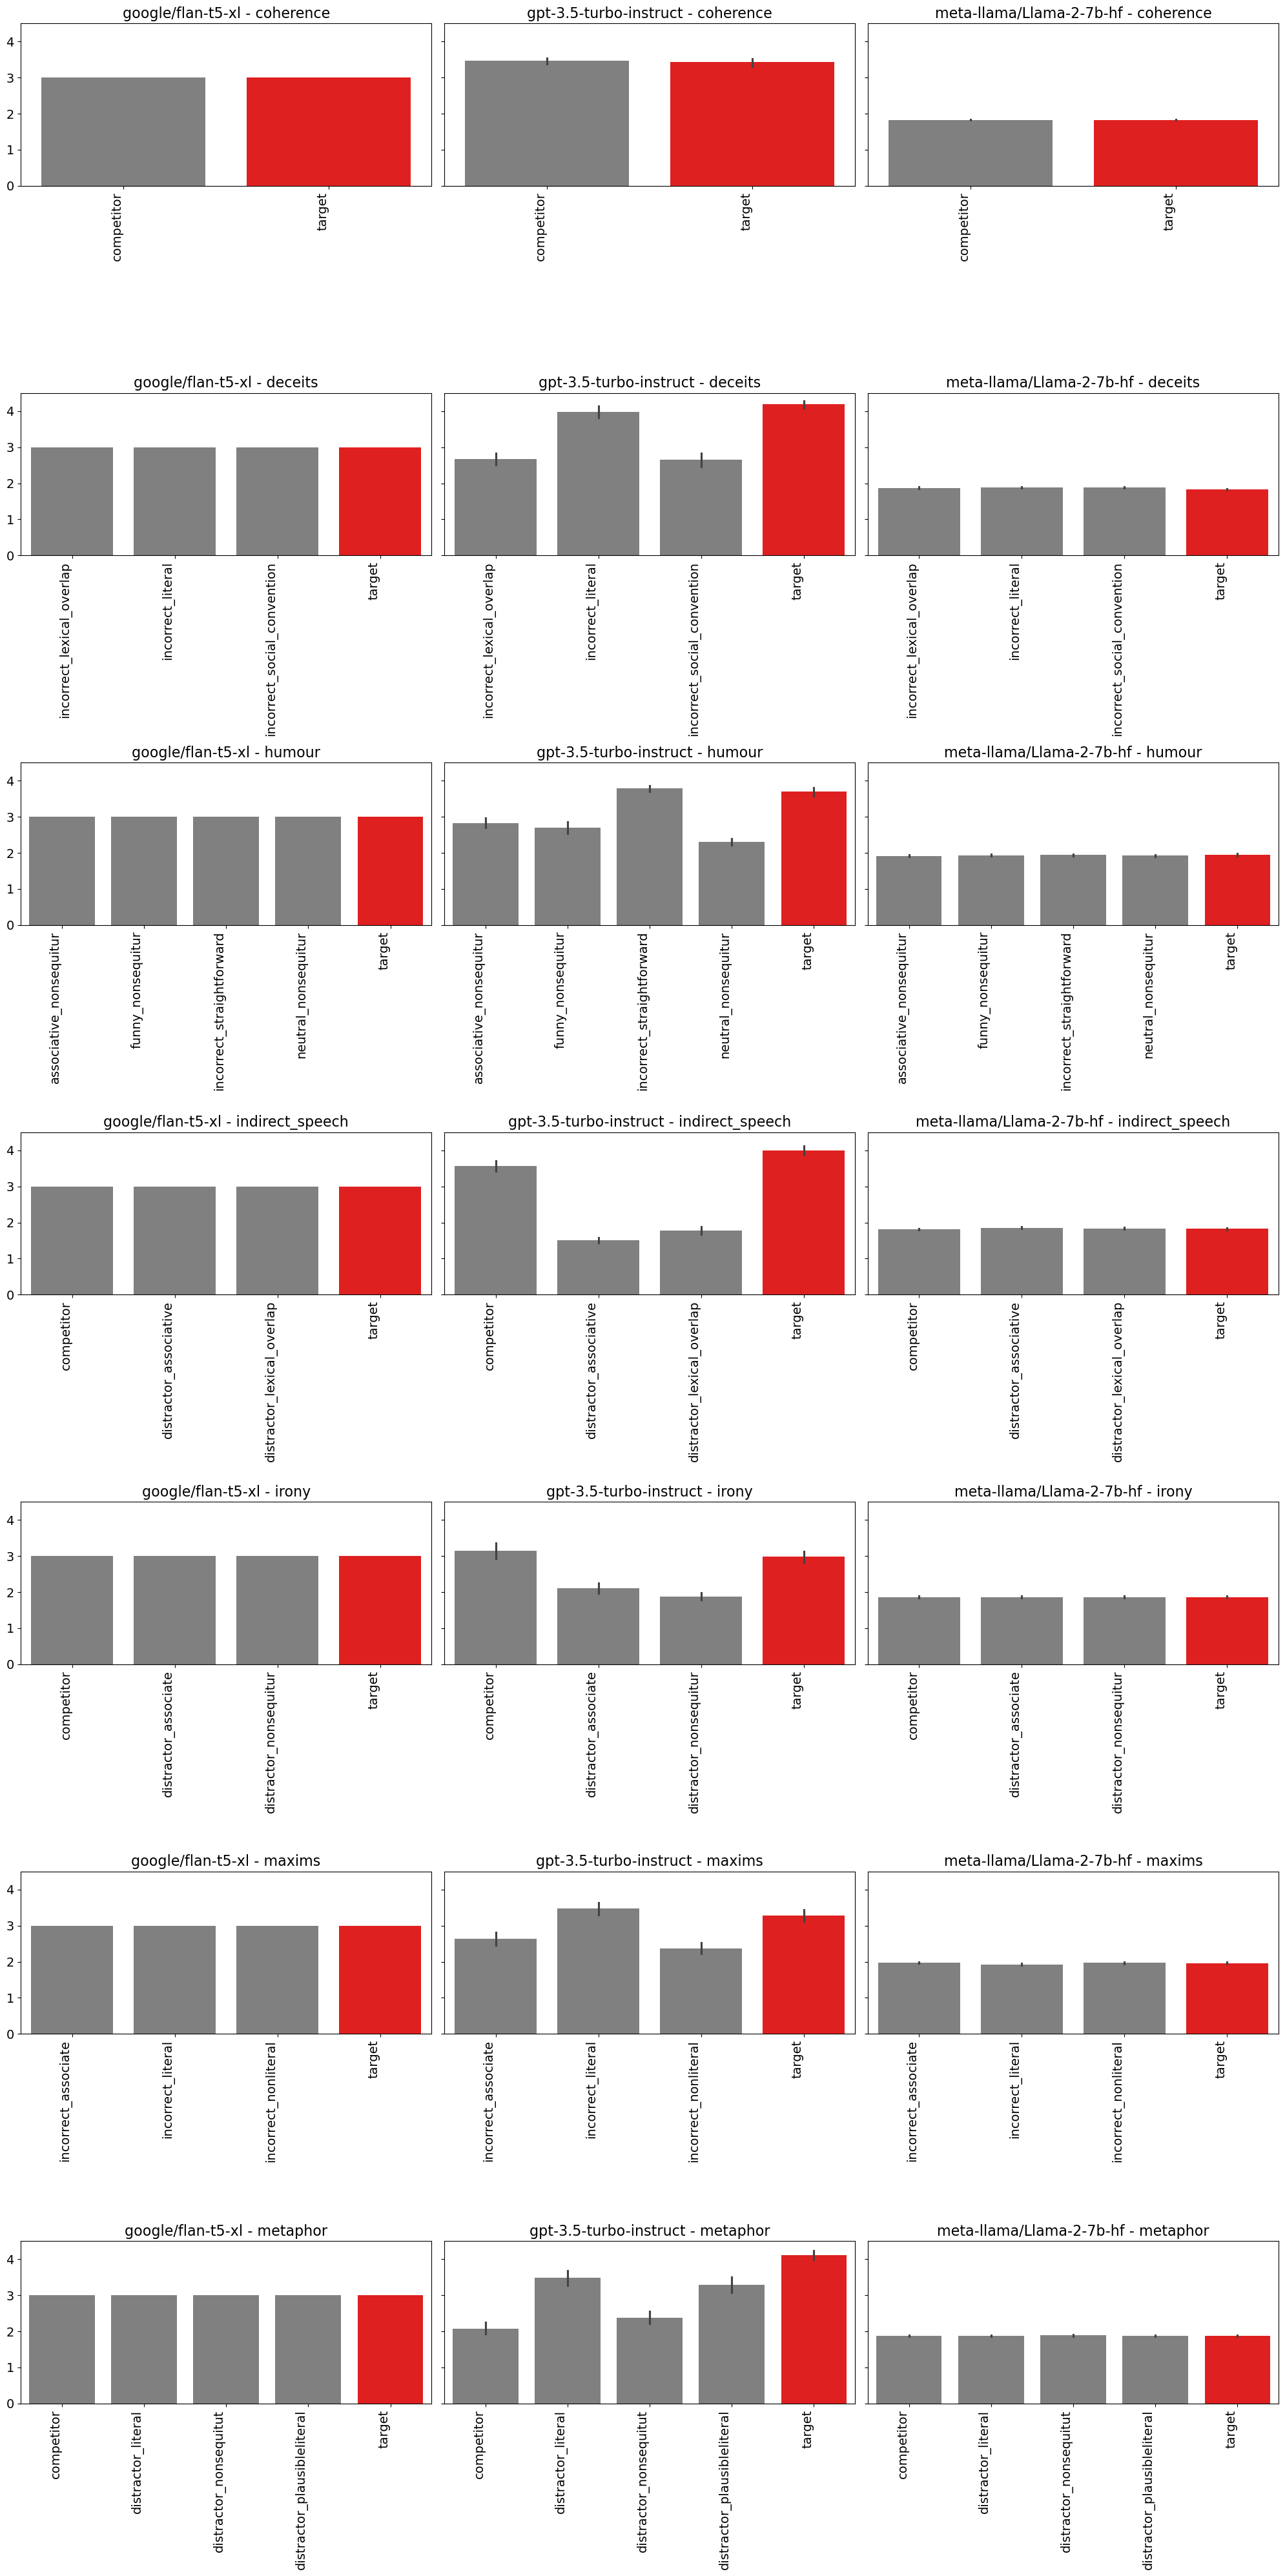

In [27]:
# Extracting unique models and phenomena based on the grouped data
unique_models = grouped_df['model_name'].unique()
unique_phenomena = grouped_df['phenomenon'].unique()

# Use a custom color palette to highlight 'target' response_option
palette = {response: 'gray' if response != 'target' else 'red' for response in grouped_df['option_names'].unique()}

# Set up the grid layout for the subplots
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=True)

# Iterate over each model and phenomenon to create individual subplots
for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset = grouped_df[(grouped_df['model_name'] == model) & (grouped_df['phenomenon'] == phenomenon)]
        if not subset.empty:
            sns.barplot(x='option_names', y='mean', data=subset, ax=ax, palette=palette, hue='option_names')
            ax.set_title(f'Model: {model} | Phenomenon: {phenomenon}')
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
            ax.grid(True, axis='y')

            # Remove all lines on background
            ax.grid(False)
            #sns.despine(left=True, bottom=True, ax=ax)

            # Set title with larger font size
            ax.set_title(f"{model} - {phenomenon}", fontsize=16)
            
            # Increase tick label size
            ax.tick_params(axis="x", rotation=90, labelsize=14)
            ax.tick_params(axis="y", labelsize=14)
            
            # Increase axis label size
            ax.set_xlabel(ax.get_xlabel(), fontsize=14)
            ax.set_ylabel(ax.get_ylabel(), fontsize=14)

# Adjust layout
fig.tight_layout()
plt.show()


In [23]:
# Define the path to save the plot as PDF
save_path = "plots/rating_w.score_distribution_by_model_phenomenon.pdf"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the plot to the specified path
fig.savefig(save_path, bbox_inches='tight')

save_path


'plots/rating_w.score_distribution_by_model_phenomenon.pdf'

/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_31202/507223713.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_31202/507223713.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_31202/507223713.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_31202/507223713.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

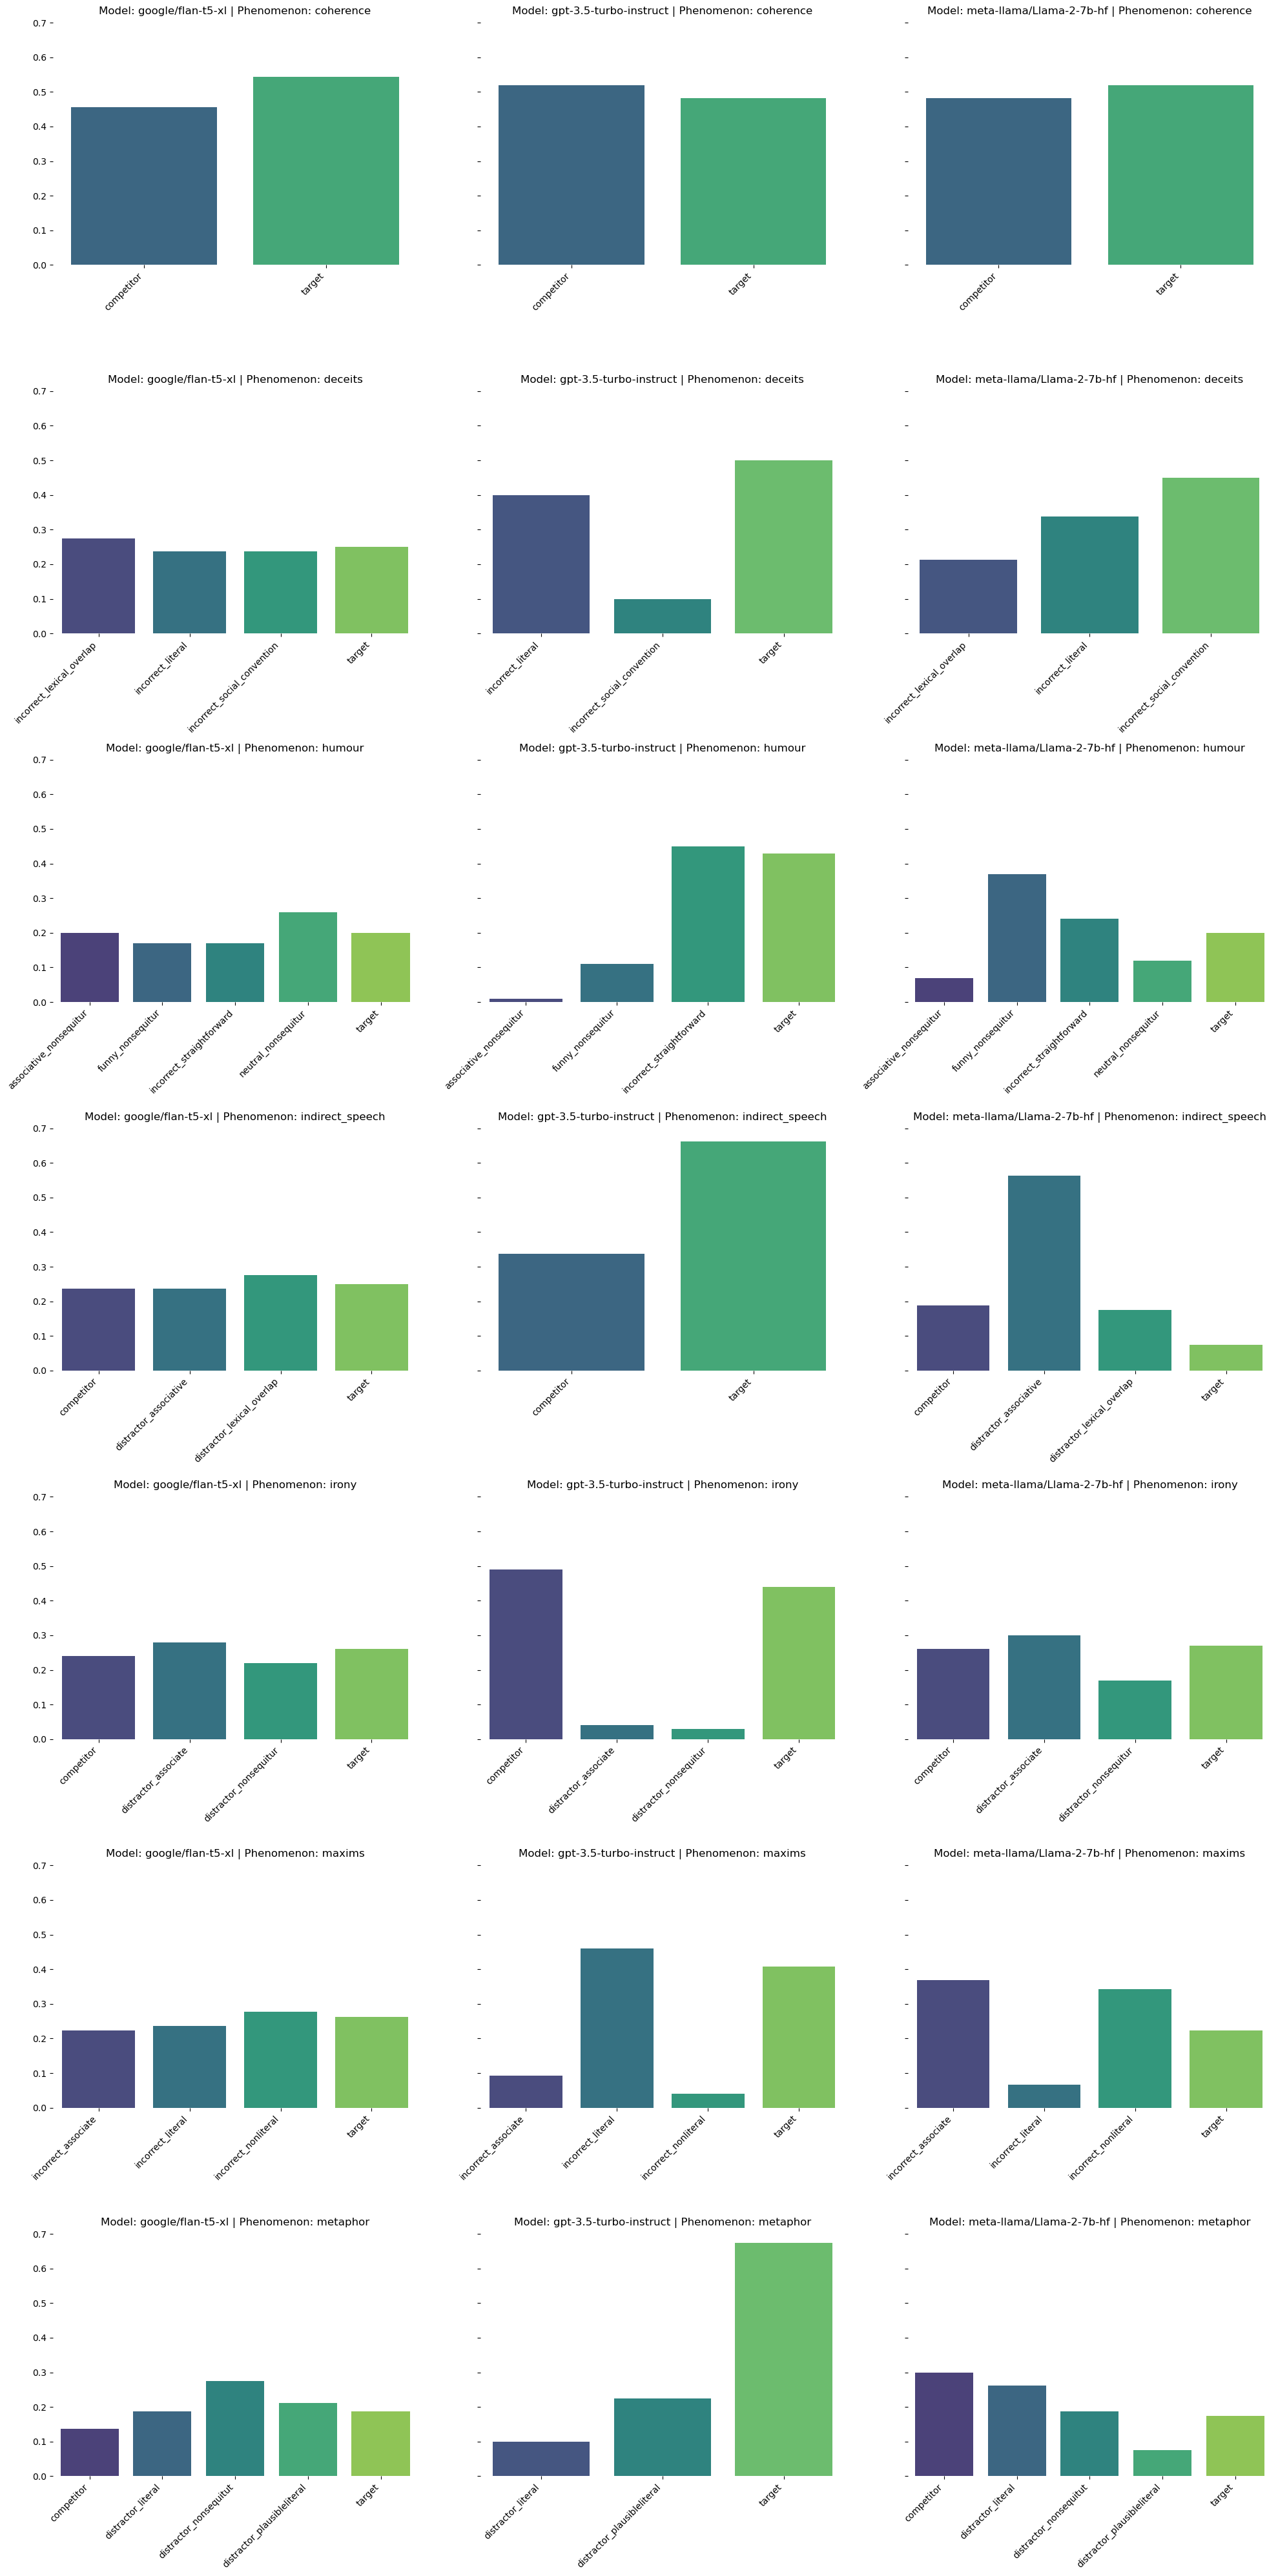

In [25]:
# Calculating the proportion of each chosen_option for each model and phenomenon combination
proportion_data = concatenated_df.groupby(['model_name', 'phenomenon', 'chosen_option']).size().reset_index(name='counts')
# Calculating the proportion of each chosen_option for each model and phenomenon combination again
total_counts = proportion_data.groupby(['model_name', 'phenomenon'])['counts'].transform('sum')
proportion_data['proportion'] = proportion_data['counts'] / total_counts
# Plotting the proportions
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=True)

for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset = proportion_data[(proportion_data['model_name'] == model) & (proportion_data['phenomenon'] == phenomenon)]
        if not subset.empty:
            sns.barplot(x='chosen_option', y='proportion', data=subset, ax=ax, palette='viridis', hue='chosen_option')
            ax.set_title(f'Model: {model} | Phenomenon: {phenomenon}')
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
            # Remove all lines on background
            ax.grid(False)
            #sns.despine(left=True, bottom=True, ax=ax)

# Adjust layout
fig.tight_layout()
plt.show()
